In [5]:
from pyomo.environ import * 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Cambiar las rutas de los archivos
clients = pd.read_csv(r'case_1_base/Clients.csv')  # Clientes
depots = pd.read_csv(r'case_1_base/Depots.csv')    # Depósitos
distancias = pd.read_csv(r'Matrices/distancias1.csv')  # Matriz de distancias
tiempos = pd.read_csv(r'Matrices/tiempos1.csv')        # Matriz de tiempos
vehicles = pd.read_csv(r'case_1_base/Vehicles.csv')    # Vehículos
costos_operativos = pd.read_csv(r'case_1_costs_vehicules\costos_operativos_combinados1.csv')   # Costos Operativos 

# Freight Rate [COP/km]
costos_km = {
    'Gas Car': 5000,
    'drone': 500,
    'EV': 4000
}

# Time Rate [COP/min]
costos_minuto = {
    'Gas Car': 500,
    'drone': 500,
    'EV': 500
}

# Daily Maintenance [COP/day]
costos_mantenimiento = {
    'V1': 30000,
    'V2': 30000,
    'V3': 30000,
    'V4': 30000,
    'V5': 21000,
    'V6': 21000,
    'V7': 21000,
    'V8': 21000,
    'V9': 21000,
    'V10': 3000,
    'V11': 3000,
    'V12': 3000,
}

# Recharge/Fuel Cost [COP/(gal or kWh)]
costos_recarga = {
    'V1': 16000,
    'V2': 16000,
    'V3': 16000,
    'V4': 16000,
    'V5': 0,
    'V6': 0,
    'V7': 0,
    'V8': 0,
    'V9': 0,
    'V10': 220.73,
    'V11': 220.73,
    'V12': 220.73,
}

# Recharge/Fuel Time [min/10% charge]
tiempo_recarga = {
    'Gas Car': 0.1,
    'drone': 2,
    'EV': 0  # Asumimos que no necesita recarga
}

# Gas Efficiency [km/gal]
eficiencia_combustible = {
    'Gas Car': 10,
    'drone': 0,  # No aplica
    'EV': 0  # No aplica
}

# Electricity Efficiency [kWh/km]
eficiencia_electrica = {
    'Gas Car': 0,  # No aplica
    'drone': 0.15,
    'EV': 0.15
}


vehicles['ID'] = ['V' + str(i+1) for i in range(len(vehicles))]

# Crear conjuntos
distancias_dict = {(int(row["Desde"]+1), int(row["Hacia"]+1)): row["Distancia"] for _, row in distancias.iterrows()}


clientes = clients['LocationID'].tolist()  # IDs de los clientes
centros = depots['LocationID'].tolist()   # IDs de los depósitos
vehiculos = vehicles['ID'].tolist()  # IDs de los vehículos
productos = ['Product']  # Definimos tipos de productos (puedes ajustar según el problema)
nodos = centros + clientes  # Todos los nodos (clientes + depósitos)
clients.columns = clients.columns.str.strip()
depots.columns = depots.columns.str.strip()

# Crear parámetros
# 1. Demandas de clientes por producto (puede venir de Clients.csv o ser constante)
demandas_clients = {(row['LocationID'], p): row['Product'] for _, row in clients.iterrows() for p in productos}
demanda_centros = {
    (row['LocationID'], p): 0
    for _, row in depots.iterrows()
    for p in productos
}
demandas = {**demandas_clients, **demanda_centros}



# 2. Capacidades de los vehículos (Vehicles.csv)
capacidad_vehiculo = {row['ID']: row['Capacity'] for _, row in vehicles.iterrows()}

# 3. Rango máximo de los vehículos (Vehicles.csv)
rango_vehiculo = {row['ID']: row['Range']*1000 for _, row in vehicles.iterrows()}
print(rango_vehiculo)
# 4. Costo operativo 
costos_operativos_dict = {(row['Vehiculo'], row['Desde'], row['Hacia']): row['Costo'] 
                          for _, row in costos_operativos.iterrows()}



# 6. Capacidades de los centros de distribución (Depots.csv)
#capacidades_centro = {(row['DepotID'], p): row[f'Capacidad_{p}'] for _, row in depots.iterrows() for p in productos}

# 7. Distancias y tiempos (distancias1.csv y tiempos1.csv)
# Convertir archivos CSV a diccionarios

tiempos_dict = {(row['Desde'], row['Hacia']): row['Tiempo'] for _, row in tiempos.iterrows()}
# Crear diccionario de coordenadas para todos los nodos
all_coords = {
    **{row['LocationID']: (row['Longitude'], row['Latitude']) for _, row in clients.iterrows()},
    **{row['LocationID']: (row['Longitude'], row['Latitude']) for _, row in depots.iterrows()}
}

# Validar dimensiones
print(f"Clientes: {len(clientes)}, Centros: {len(centros)}, Vehículos: {len(vehiculos)}, Nodos: {len(nodos)}")





{'V1': 145852.07096486446, 'V2': 195690.8956922408, 'V3': 142975.8912915246, 'V4': 173023.04187458724, 'V5': 1108512.0087171928, 'V6': 906854.0492859486, 'V7': 617343.9510684405, 'V8': 887542.4941518055, 'V9': 1062849.466519055, 'V10': 10763.088895994128, 'V11': 14322.671098540392, 'V12': 10725.75544135963}
Clientes: 24, Centros: 12, Vehículos: 12, Nodos: 36


In [ ]:
class VRPModel:
    def __init__(self, clientes, centros, vehiculos, productos, distancias_dict, tiempos, demandas, capacidad_vehiculo, rango_vehiculo, costos_operativos_dict, costos_mantenimiento, costos_recarga,all_coords):
        """
        Inicializar parámetros del modelo VRP.
        """
        # Conjuntos y parámetros
        self.clientes = clientes
        self.centros = centros
        self.vehiculos = vehiculos
        self.productos = productos
        self.nodos = clientes + centros
        self.distancias_dict = distancias_dict
        self.tiempos = tiempos
        self.demandas = demandas
        self.capacidad_vehiculo = capacidad_vehiculo
        self.rango_vehiculo = rango_vehiculo
        self.costos_operativos_dict= costos_operativos_dict
        self.costos_mantenimiento = costos_mantenimiento
        self.costos_recarga = costos_recarga
        self.all_coords = all_coords

        
        
        # Crear modelo Pyomo
        self.model = ConcreteModel()

    def build_model(self):
        """
        Construir el modelo de optimización.
        """
        model = self.model

        # Sets
        model.C = Set(initialize=self.clientes)
        model.D = Set(initialize=self.centros)
        model.V = Set(initialize=self.vehiculos)
        model.P = Set(initialize=self.productos)
        model.N = Set(initialize=self.nodos) 

        # Variables
        model.x = Var(model.N, model.N, model.V, within=Binary)  # Ruta del vehículo
        model.z = Var(model.V, within=Binary)  # Activación del vehículo
        model.q = Var(model.N, model.P, model.V, within=NonNegativeReals)  # Carga transportada

        # Función objetivo: Minimizar costos
        def obj_expression(model):
            return sum(
                # Costos por distancia
                model.x[i, j, v] * costos_operativos_dict[(v, i, j)]
                for v in model.V for i in model.N for j in model.N if (v, i, j) in costos_operativos_dict) + sum(
                # Costos de mantenimiento
                model.z[v] * self.costos_mantenimiento[v] for v in model.V)
            + sum(
                # Costos de recarga
                self.costos_recarga[v] * model.z[v] for v in model.V
            )
        model.obj = Objective(rule=obj_expression, sense=minimize)
        
        # Restricciones

        # 1. Cada cliente debe ser visitado exactamente una vez
        def restriccion_visita_unica(model, i):
            return sum(model.x[i, j, v] for j in model.N for v in model.V if i != j) == 1
        model.restriccion_visita_unica = Constraint(model.C, rule=restriccion_visita_unica)

        # 2. Conservación del flujo en los nodos
        def restriccion_flujo(model, i, v):
            return sum(model.x[i, j, v] for j in model.N if i != j) == sum(model.x[j, i, v] for j in model.N if i != j)
        model.restriccion_flujo = Constraint(model.N, model.V, rule=restriccion_flujo)

        # 3. Capacidad de los vehículos
        def restriccion_capacidad_vehiculo(model, v):
            return sum(model.q[i, p, v] for i in model.C for p in model.P) <= self.capacidad_vehiculo[v]
        model.restriccion_capacidad_vehiculo = Constraint(model.V, rule=restriccion_capacidad_vehiculo)

        #4. No viajes a si mismo
        def restriccion_no_viajes(model, i, v):
            return model.x[i, i, v] == 0
        model.restriccion_no_viajes = Constraint(model.N, model.V, rule=restriccion_no_viajes)
        
        #5. No viaaje de un deposito a otro deposito
        def restriccion_no_viajes_centros(model, i, j, v):
            return model.x[i, j, v] == 0
        model.restriccion_no_viajes_centros = Constraint(model.D, model.D, model.V, rule=restriccion_no_viajes_centros)
        
        # 5. Capacidad de los centros de distribución
        # def restriccion_capacidad_centro(model, k, p):
        #     return sum(model.q[i, p, v] for i in model.C for v in model.V) <= self.capacidades_centro[k, p]
        # model.restriccion_capacidad_centro = Constraint(model.D, model.P, rule=restriccion_capacidad_centro)

        # 6. Límite de rango de los vehículos
        def restriccion_rango_vehiculo(model, v):
            return sum(self.distancias_dict[(i, j)] * model.x[i, j, v] for i in model.N for j in model.N if i != j) <= self.rango_vehiculo[v]
        model.restriccion_rango_vehiculo = Constraint(model.V, rule=restriccion_rango_vehiculo)
        
        

        #7. Restricción de activación de vehículos
        M= len(self.nodos)
        def restriccion_activacion_vehiculo(model, v):
            return sum(model.x[i, j, v] for i in model.N for j in model.N if i != j) <= M * model.z[v]
        model.restriccion_activacion_vehiculo = Constraint(model.V, rule=restriccion_activacion_vehiculo)

        # 8. Eliminación de subtours (MTZ)
        model.u = Var(model.N, model.V, within=NonNegativeReals)
        def restriccion_subtours(model, i, j, v):
            if i != j:
                return model.u[i, v] - model.u[j, v] + len(model.N) * model.x[i, j, v] <= len(model.N) - 1
            return Constraint.Skip
        model.restriccion_subtours = Constraint(model.C, model.C, model.V, rule=restriccion_subtours)

        #9. Sale de un centro depot
        def restriccion_sale_vehiculo(model,v):
            return sum(model.x[d,j,v] for d in model.D for j in model.N)==1
        model.restriccion_sale_vehiculo= Constraint(model.V, rule= restriccion_sale_vehiculo)
        
        def restriccion_entra_vehiculo(model,v):
            return sum(model.x[i,d,v] for d in model.D for i in model.N)==1
        model.restriccion_entra_vehiculo= Constraint(model.V, rule= restriccion_entra_vehiculo)
        
        return model
    

    
    
    def solve_model(self):
        """
        Resolver el modelo utilizando HiGHS.
        """
        solver_name = "appsi_highs"
        solver = SolverFactory(solver_name)
        solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 5*60  # 1-hour time limit
        solver.options['presolve'] = 'on'
        solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        solver.options['simplex_strategy'] = 1  # Dual simplex
        solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        # Resolver el modelo
        result = solver.solve(self.model, tee=True)

        # Verificar el estado del solver
        if result.solver.termination_condition == TerminationCondition.infeasible:
            print("El modelo es infactible.")
        elif result.solver.termination_condition == TerminationCondition.optimal:
            print("Se encontró una solución óptima.")
            # Cargar la solución si es óptima
            self.model.solutions.load_from(result)
        elif result.solver.termination_condition == TerminationCondition.unbounded:
            print("El modelo es no acotado.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Se alcanzó el límite de tiempo.")
        else:
            print(f"Condición de terminación desconocida: {result.solver.termination_condition}")

        print(result)

        
    def display_results(self):
        print("\nRutas asignadas por vehículo:")
        for v in self.vehiculos:
            print(f"Vehículo: {v}")
            for i in self.nodos:
                for j in self.nodos:
                    if i != j and round(value(self.model.x[i, j, v])) == 1:  # Redondeamos el valor
                        print(f"   De {i} a {j}")
                        

    def visualize_routes(self):
        valid_edges = []
        for v in self.vehiculos:
            for i in self.nodos:
                for j in self.nodos:
                    if i != j and round(value(self.model.x[i, j, v])) == 1:  # Redondeamos el valor
                        valid_edges.append((i, j, v))

        G = nx.DiGraph()
        for i, j, v in valid_edges:
            G.add_edge(i, j, vehicle=v)

        # Asignar colores distintos por vehículo
        edge_colors = [self.vehiculos.index(v) for _, _, v in valid_edges]
        cmap = plt.cm.get_cmap('tab10', len(self.vehiculos))

        pos = {node: (coord[0], coord[1]) for node, coord in self.all_coords.items()}

        # Crear la figura y el eje
        fig, ax = plt.subplots(figsize=(12, 10))

        # Dibujar el grafo
        nx.draw(
            G,
            pos,
            ax=ax,  # Especificamos el eje
            with_labels=True,
            edge_color=edge_colors,
            node_size=500,
            node_color='lightblue',
            font_size=10,
            edge_cmap=cmap,
            connectionstyle="arc3,rad=0.1"
        )

        # Crear un ScalarMappable para la barra de colores
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(self.vehiculos) - 1))
        sm.set_array([])  # Necesario para evitar errores

        # Agregar la barra de colores al eje
        cbar = plt.colorbar(sm, ax=ax, shrink=0.8)  # Asociar al eje actual
        cbar.set_ticks(range(len(self.vehiculos)))
        cbar.ax.set_yticklabels(self.vehiculos)  # Etiquetas de los vehículos

        plt.title("Rutas Optimizadas de Vehículos")
        plt.show()






Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 4e+04]
  Cost   [9e+02, 2e+05]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+06]
Presolving model
7128 rows, 11823 cols, 79448 nonzeros  0s
6568 rows, 11337 cols, 70199 nonzeros  7s

Solving MIP model with:
   6568 rows
   11337 cols (11049 binary, 0 integer, 0 implied int., 288 continuous)
   70199 nonzeros
MIP-Timing:         9.3 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Conf

C:\Users\user\AppData\Local\Temp\ipykernel_8104\1777580270.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(self.vehiculos))


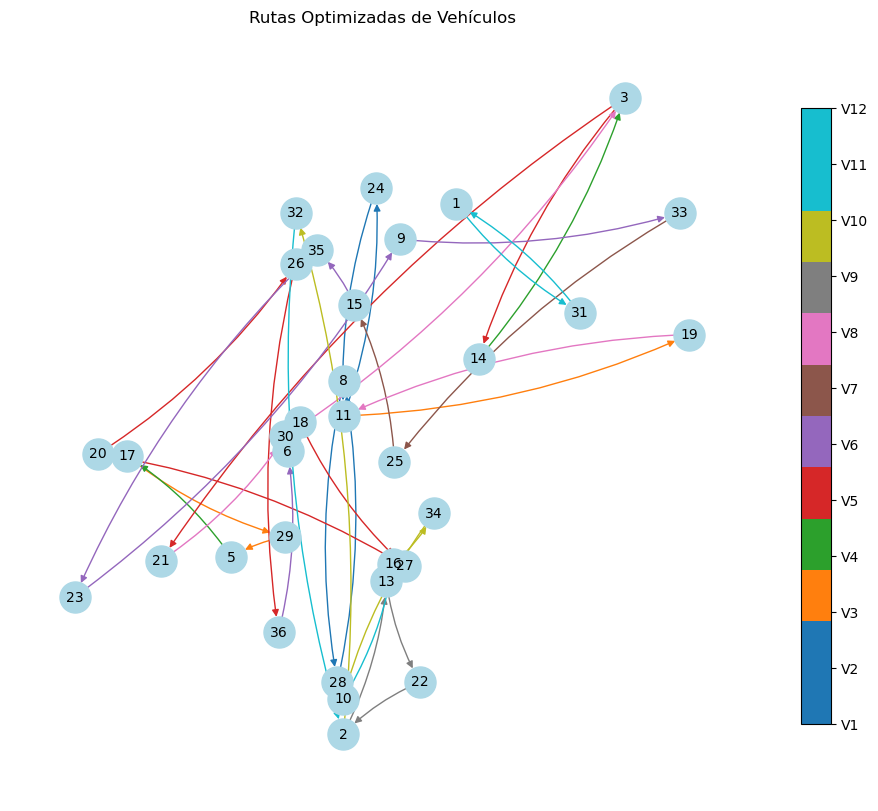

In [7]:
# Instanciar la clase del modelo
vrp = VRPModel(
    clientes=clientes,
    centros=centros,
    vehiculos=vehiculos,
    productos=productos,
    distancias_dict=distancias_dict,
    tiempos=tiempos,
    demandas=demandas,
    capacidad_vehiculo=capacidad_vehiculo,
    rango_vehiculo=rango_vehiculo,
    costos_operativos_dict=costos_operativos_dict,
    costos_mantenimiento=costos_mantenimiento,
    costos_recarga=costos_recarga,
    all_coords=all_coords
)

# Construir el modelo
vrp.build_model()

# Resolver el modelo
vrp.solve_model()

vrp.display_results()

vrp.visualize_routes()

In [8]:
vrp.model.display()

Model unknown

  Variables:
    x : Size=15552, Index=N*N*V
        Key             : Lower : Value                  : Upper : Fixed : Stale : Domain
           (1, 1, 'V1') :     0 :                    0.0 :     1 : False : False : Binary
          (1, 1, 'V10') :     0 :                    0.0 :     1 : False : False : Binary
          (1, 1, 'V11') :     0 :                    0.0 :     1 : False : False : Binary
          (1, 1, 'V12') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V2') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V3') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V4') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V5') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V6') :     0 :                    0.0 :     1 : False : False : Binary
           (1, 1, 'V7') :     0 :       